In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# load the data from the csv file and use the date as the index
data = pd.read_csv('InvestmentReplica.csv', header=0)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, dayfirst=True)
# divide it into indexes and futures
indexes = data[['MXWO','MXWD','LEGATRUU','HFRXGL']]
futures = data[['RX1','TY1','GC1','CO1','ES1','VG1',
    'NQ1','LLL1','TP1','DU1', 'TU2' ]]

# Data exploration

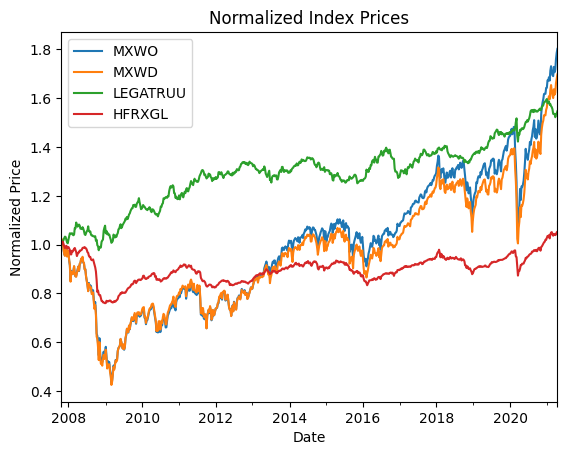

In [9]:
# plot the indexes
indexes_plot = indexes.div(indexes.iloc[0]).plot()
indexes_plot.set_ylabel('Normalized Price')
indexes_plot.set_xlabel('Date')
indexes_plot.set_title('Normalized Index Prices')
plt.show()